## Part IV: Elastic Net Regression using Gradient Descent

1. Import Libraries and read dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

In [2]:
emission_data = pd.read_csv('./preprocessed/emissions_preprocessed.csv')

In [3]:
emission_data

,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Per Capita
0,afghanistan,1990.0,2.024326,0.278464,1.271408,0.403040,0.045766,0.025648,0.189281
1,afghanistan,1991.0,1.914301,0.249627,1.204085,0.389125,0.045766,0.025697,0.178155
2,afghanistan,1992.0,1.482054,0.021984,1.029584,0.362736,0.045766,0.021984,0.122916
3,afghanistan,1993.0,1.486943,0.018320,1.047904,0.298744,0.035550,1251.000000,0.106182
4,afghanistan,1994.0,1.453829,0.014693,1.032171,0.337935,0.046991,0.022039,0.094065
...,...,...,...,...,...,...,...,...,...
3081,global,2017.0,36096.739276,14506.973805,12242.627935,7144.928128,1507.923185,391.992176,4.749682
3082,global,2018.0,36826.506600,14746.830688,12266.016285,7529.846784,1569.218392,412.115746,4.792753
3083,global,2019.0,37082.558969,14725.978025,12345.653374,7647.528220,1617.506786,439.253991,4.775633
3084,global,2020.0,35264.085734,14174.564010,11191.808551,7556.290283,1637.537532,407.583673,4.497423


2. Data Analysis and Preprocessing

In [4]:
# Drop rows where Country = 'global' - not required in this case
emission_data = emission_data[emission_data['Country'] != 'global']

In [5]:
# Get Top poluted countries 
country_list = emission_data['Country'].unique()

temp = {}
for c in country_list:
    total_avg_pollution = float(emission_data[emission_data['Country'] == c]['Total'].mean())
    temp[c] = total_avg_pollution

top_polluted_countries = dict(sorted(temp.items(), key=lambda item: item[1], reverse=True))

list_top = list(top_polluted_countries.keys())
print(list_top[:20]) # Print top 20 polluted countries

['china', 'usa', 'russia', 'india', 'japan', 'germany', 'canada', 'united kingdom', 'south korea', 'iran', 'italy', 'mexico', 'south africa', 'brazil', 'france', 'indonesia', 'australia', 'poland', 'ukraine', 'spain']


In [6]:
# Create a model for top 20 polluted countries

top_polluted_country_data = emission_data[emission_data['Country'].isin(list_top[:20])]

In [7]:
top_polluted_country_data # This will be our filtered dataset

,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Per Capita
153,australia,1990.0,278.154156,141.879819,88.842090,34.454816,3.462872,7.272496,16.315938
154,australia,1991.0,279.528510,146.082840,88.245572,32.786243,3.183033,7.001201,16.184767
155,australia,1992.0,284.525345,150.051381,87.916828,33.970472,2.923411,7.303701,16.293502
156,australia,1993.0,288.870537,150.098575,90.386578,35.670002,3.004698,7.136743,16.383765
157,australia,1994.0,293.696553,151.376241,91.924087,37.032005,3.484276,6.880148,16.494706
...,...,...,...,...,...,...,...,...,...
2923,usa,2017.0,5210.957584,1308.479533,2314.675386,1460.391796,40.323535,59.245489,15.800777
2924,usa,2018.0,5376.657233,1256.201494,2365.283480,1618.720337,38.970745,72.786925,16.187923
2925,usa,2019.0,5259.143836,1070.723931,2358.831137,1673.999100,40.895869,88.383147,15.730884
2926,usa,2020.0,4715.691109,878.972885,2049.336500,1653.677852,40.687747,67.684371,14.037218


In [8]:
top_polluted_country_data = top_polluted_country_data.drop(columns=['Total']) # Drop 'Total' column because it is not related

In [9]:
# Create a dictonary where every country is mapped to a unique number
country_code = {}
for i, country in enumerate(top_polluted_country_data['Country'].unique()):
    country_code[country] = i+1

country_code

{'australia': 1,
 'brazil': 2,
 'canada': 3,
 'china': 4,
 'france': 5,
 'germany': 6,
 'india': 7,
 'indonesia': 8,
 'iran': 9,
 'italy': 10,
 'japan': 11,
 'mexico': 12,
 'poland': 13,
 'south korea': 14,
 'russia': 15,
 'south africa': 16,
 'spain': 17,
 'ukraine': 18,
 'united kingdom': 19,
 'usa': 20}

In [10]:
top_polluted_country_data['Country_code'] = top_polluted_country_data['Country'].map(country_code)

In [11]:
# Drop Country column
top_polluted_country_data = top_polluted_country_data.drop(columns=['Country'], axis=1)

3. Choose target Y and split the dataset

- Here I choose the 'Country_code' as the target variable.

In [12]:
# Reusing my code from Part III

copy_emission_data = top_polluted_country_data

# Split data into 80% training and 20% testing set
training_set = copy_emission_data.sample(frac=0.8, random_state=42)
test_set = copy_emission_data.drop(training_set.index)

print("train data shapes: ", training_set.shape)
print("test data shapes: ", test_set.shape)


train data shapes:  (490, 8)
test data shapes:  (123, 8)


4. Normalize

In [13]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

In [14]:
for column in ['Year', 'Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Per Capita']:
    training_set[column] = normalize(training_set[column])

for column in ['Year', 'Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Per Capita']:
    test_set[column] = normalize(test_set[column])

In [15]:
training_set.describe()

,Year,Coal,Oil,Gas,Cement,Flaring,Per Capita,Country_code
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,0.511192,0.069379,0.145068,0.083460,0.017666,0.008898,0.009076,10.559184
std,0.296877,0.159041,0.205525,0.132286,0.065910,0.067919,0.063607,5.792030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.258065,0.007565,0.055134,0.021079,0.001740,0.000898,0.002383,6.000000
50%,0.516129,0.021223,0.085315,0.041545,0.004670,0.001459,0.003811,10.000000
75%,0.774194,0.050203,0.122055,0.067211,0.009267,0.004098,0.005303,16.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000


In [16]:
# Reusing my code from Part III

x_train = training_set.drop('Country_code', axis=1)
y_train = training_set['Country_code']

x_test = test_set.drop('Country_code', axis=1)
y_test = test_set['Country_code']

print("train data shapes: ", x_train.shape, y_train.shape)
print("test data shapes: ", x_test.shape, y_test.shape)

train data shapes:  (490, 7) (490,)
test data shapes:  (123, 7) (123,)


5. Implement Elastic Net Regularization

In [17]:
# Using my code from Part II

class ElasticNetReg():
    def __init__(self, learning_rate, iterations):
        self.weights = None
        self.alpha = learning_rate
        self.iterations = iterations
        self.loss = []
        self.n = None
        self.features = None
        self.dgrad = []
    
    def cost(self, X, y, lam1, lam2):  
        dy = y - np.dot(X, self.weights)
        mse = (1/2*self.n) * np.sum(dy**2)
        l1_penalty = lam1 * np.sum(np.abs(self.weights[1:]))  # Exclude bias term
        l2_penalty = (lam2 / 2) * np.sum(self.weights[1:] ** 2)  # Exclude bias term
        jw = mse + l1_penalty + l2_penalty 
        return jw

    def gradient_descent(self, X, y, lam1, lam2, iter):
        dy = y - np.dot(X, self.weights)
        # Gradient for MSE term
        gradient_mse = -np.dot(X.T, dy) / self.n

        # Gradient for L1 
        l1_grad = lam1 * np.sign(self.weights)
        l1_grad[0] = 0  # No L1 for bias term

        # Gradient for L2 
        l2_grad = lam2 * self.weights
        l2_grad[0] = 0  # No L2 for bias term

        # Total gradient
        dw = gradient_mse + l1_grad + l2_grad

        self.dgrad.append(dw)

        if np.all(np.abs(dw) < 0.01):
            print(f"gradient stop at iteration = {iter}")
            return True
       
        self.weights -= self.alpha * dw # Update weights
        return False

    def fit(self, X, y, lam1, lam2, w):
        self.n = X.shape[0]

        self.weights = w
        self.weights[0] = 1 #for bias term

        # Add ones to starting row for bias term
        X = np.column_stack((np.ones(X.shape[0]), X))

        for i in range(self.iterations):
            loss = self.cost(X, y, lam1, lam2) # Compute J(w)
            t = self.gradient_descent(X, y, lam1, lam2, i)
            if t:
                break
            # print(f"loss for iteration {i} = {loss}")
            self.loss.append(loss)

        pickle.dump(self.weights, open("part4.p", "wb" ))

        return 
    
    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        return np.dot(X, self.weights)



In [18]:
emission_model = ElasticNetReg(0.001, 200000)


In [19]:
# Xavier Initialization of Weights

def xavier_initialization(input_dim, output_dim):
    # Calculate the limit for uniform distribution
    limit = np.sqrt(6 / (input_dim + output_dim))
    # Initialize weights with uniform distribution in the range[-limit, limit]
    weights = np.random.uniform(-limit, limit, size=(input_dim,output_dim))

    return weights.flatten()

In [20]:
# Different methods of weight initialization

initial_w1 = np.random.rand(1 + x_train.shape[1]) # Initialize random weights

initial_w2 = np.zeros(1 + x_train.shape[1]) # Initialize zero

initial_w3 = xavier_initialization(1 + x_train.shape[1], 1) # Using Xavier's initialization

In [21]:

emission_model.fit(x_train, y_train, 0.001, 0.01, initial_w3)

gradient stop at iteration = 111655


In [22]:
# Finding best Hyperparameters - weights, lam1m lam2 for 10000 iterations

best_lam1 = 0
best_lam2 = 0
min_loss = 1e20
best_w = 0
weight_methods = [initial_w1, initial_w2, initial_w3]
for w in range(len(weight_methods)):
    for i in [0.01, 0.05, 0.1, 0.5, 1]:
        for j in [0.01, 0.05, 0.1, 0.5, 1]:
            model = ElasticNetReg(0.01, 10000)
            model.fit(x_train, y_train, 0.1, 0.1, weight_methods[w])
            if model.loss[-1] < min_loss:
                min_loss = model.loss[-1]
                best_lam1 = i
                best_lam2 = j
                best_w = w + 1
            # print(f"L1 = {i}, L2 = {j}, W = w{w+1}, Loss = {model.loss[-1]}")
            
print(f"\nbest lambda1 : {best_lam1}, best lambda2 : {best_lam2}, best weight = w{best_w}, min loss : {min_loss}")


best lambda1 : 0.01, best lambda2 : 0.01, best weight = w3, min loss : 3898194.547057146


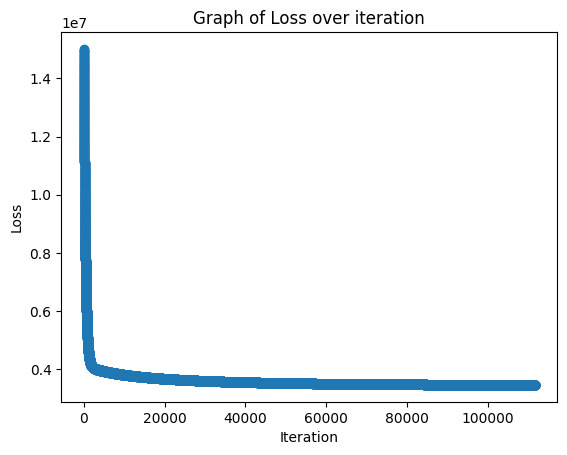

In [23]:
plt.scatter(range(len(emission_model.loss)), emission_model.loss)
plt.title("Graph of Loss over iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [24]:
emission_model.loss[-1]

3453285.3460513204

In [25]:
y_pred = emission_model.predict(x_test)

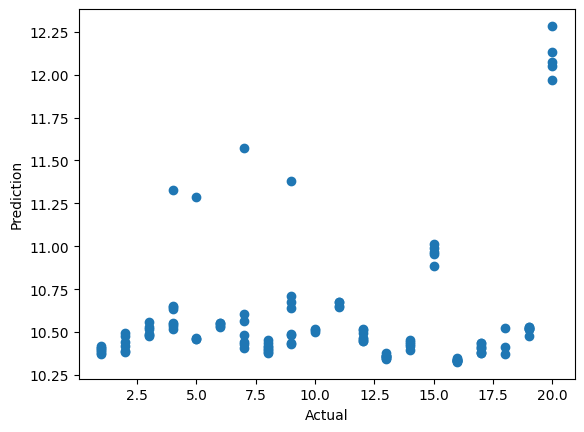

In [26]:
# Plot: Actual vs Predicted output

plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.show()

In [27]:
# Save weights as pickle file
# import pickle

# pickle.dump(emission_model.weights, open("ha33_assignment1_part4.p", "wb" ))

# print("Weights stores as pickle file")
